# MACHINE LEARNING

# Importing Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from itertools import combinations
from scipy.stats import ttest_ind  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.metrics import calinski_harabasz_score


# Reloading Data

In [5]:
red_wine_data = pd.read_csv('winequality-red.csv', delimiter=';')
white_wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
combined_wine_data = pd.concat([red_wine_data, white_wine_data], ignore_index=True)

# Data Transformation

## Creating a Binary Feature

In [8]:
combined_wine_data['QualityCategory'] = combined_wine_data['quality'].apply(lambda x: 'POOR' if x <= 5 else 'GOOD')

The new created categorical column is named as 'QualityCategory' in the dataset.

## Preprocessing

In [11]:
# Separating predictors (x) and the response (y) variable:
x = combined_wine_data.drop(columns=['quality', 'QualityCategory'])  # excluding quality in both numerical and categorical columns
y = combined_wine_data['quality']  #  numerical quality is the response variable

# Standardizing the predictor variables:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Modeling

## Linear Regression

In [14]:
# Using sklearn package
# Fitting a linear regression model:
regressor = LinearRegression()
regressor.fit(x_scaled, y)

# Printing the coefficients and intercept of the fitted model:
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)
print("\n")

# Calculating the p-val of the coefficients, with statsmodels package:
x_with_intercept = sm.add_constant(x_scaled)
model = sm.OLS(y, x_with_intercept)  
results = model.fit()

print("P-values for the coefficients:")
print(results.pvalues)
print("\n")


Coefficients: [ 0.08774096 -0.21860267 -0.01593384  0.20722804 -0.01694492  0.10595378
 -0.14023679 -0.1648152   0.07062775  0.11431158  0.31846532]
Intercept: 5.818377712790518


P-values for the coefficients:
const    0.000000e+00
x1       1.406093e-05
x2       1.336005e-64
x3       1.684750e-01
x4       3.603699e-17
x5       1.460010e-01
x6       2.224561e-15
x7       3.859922e-19
x8       6.041018e-06
x9       1.195226e-06
x10      8.951638e-24
x11      2.689724e-56
dtype: float64




We can assume a general threshold for p-val as 0.05. The x values which has lower p-val than this threshold are significant. According to this, only x3 (citric acid, p = 0.168) and x5 (free sulfur dioxide, p = 0.146) are not significant in the model. It means, the model coefficients for these parameters are not reliable like the others. For the significant one, that means, if all the other inidcators were taken as zero (at their own mean value, as the data were actually standardized) except that particular indicator, their coefficient would meaningfully lead to a well targeted model result with the linear model equation. If all the indicators were taken as zero, the intercept would lead to a quality of 5.8184. To note, although these values are not likely to be modified when desired, in these wine samples, the general logic of the multiple linear regression works in this way of interpretation. In addition, the indicators with negative signs (volatile acidity, citric acid, chlorides, total sulfur dioxide and density) decrease the quality of the sample as they increase, provided that they are significant (p-value < 0.05); indicators with positive signs (all the rest of the indicators) improve the quality of the sample as they increase, provided that they are significant (p-value < 0.05). Alcohol content is a very high contributor with the greatest coefficient in the model, meaning a unit increase in its magnitude will affect the quality heavily in good way, and this appears as a very significant result with a very small p-val. The second biggest contributor is volatile acidity with a negative impact and then the residual sugar with a positive effect.         


**Feature Selection**

The same x and y datasets defined in the previous section are used below.

Non-scaled data are used, to work with the raw data.   

In [18]:
def forward_selection(x, y):
   
    initial_features = x.columns.tolist()
    best_aic = float('inf')  
    best_model = None
    best_features = []

    for num_features in range(1, len(initial_features) + 1):
        for combo in combinations(initial_features, num_features):
            x_subset = x[list(combo)]
            x_subset_with_intercept = sm.add_constant(x_subset)  

            model = sm.OLS(y, x_subset_with_intercept).fit()
            aic = model.aic

            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_features = combo

    return best_model, best_features

best_model, best_features = forward_selection(x, y)

print(f"Best features selected by forward selection: {best_features}")
print(best_model.summary())

Best features selected by forward selection: ('fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol')
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     267.4
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:19:11   Log-Likelihood:                -7216.4
No. Observations:                6497   AIC:                         1.445e+04
Df Residuals:                    6486   BIC:                         1.453e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
        

***Discussion:***
10 features are identified as the best features by the forward selection: fixed acidity, volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol. This is a very high number, indicating almost all of the features came as important. However, at the rgression model, among those features, chlorides has a high p-value (0.091), which means its coefficient is not significant. In addition, only 0.291 (R2) of the quality observations variability was explained in this regression model. 
In terms of the comparison with the previous model, chlorides was a statistically significant indicator in the previous model in Part 4.c. Also, the indicators with new negatively signed coefficients (volatile acidity, chlorides, total sulfur dioxide and density) which decrease the quality of wine as they increase were consistently negative signed also in the previous model in section at performing the linear regression and there is no additional change in the signs.    

## Random Forest Regressor

**Dataset Division for Training and Test**

In [22]:
# Like in the previous section, separating predictors and responses again:
x = combined_wine_data.drop(columns=['quality', 'QualityCategory'])  
y = combined_wine_data['quality'] 

# Splitting the data into 75% training and 25% test sets:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101)

# Checking the size of the training and test sets, to verify the division:
print(f"Training set size: {x_train.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

Training set size: 4872
Test set size: 1625


**Model Fitting**

In [24]:
# Initializing a Random Forest model with 10 trees:
rf_model = RandomForestRegressor(n_estimators=10, random_state=101)

# Fitting the model on the training dataset:
rf_model.fit(x_train, y_train)

# Checking feature importances:
feature_importances = rf_model.feature_importances_

# Creating a new DataFrame to store features and their importances:
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Displaying the top 5 most important features
print(importance_df.head())

                Feature  Importance
10              alcohol    0.252908
1      volatile acidity    0.124120
5   free sulfur dioxide    0.094749
9             sulphates    0.086997
3        residual sugar    0.071142


***Discussion:*** The alcohol being the biggest contributer and volatile acidity the second are similar to the findings in the section of Linear Regression. Using these infromation together, we can say that alcohol content highly affects the wine quality and positively, while volatile acidity is also very important and it is the most negatively influencing indicator. While residual sugar had third biggest coefficient there, it is also in the top 5 most imortant indicators in case of this Random Forest regression model at 5th order. Also, in this case, free sulfur dioxide is slightly more important than sulphates, while according to the coefficients of the previous model (linear regression in previous section), sulphates had slightly higher coefficient the other way around.

These slight shifts are normal as Random Forests can handle also the more comlex relations without assuming a linear relation between the predictors and the target. These higher interactions may be related to collinearity between some predictors affecting each other and eventually the wine quality in more complex ways. 

**Test Predictions on the Model**

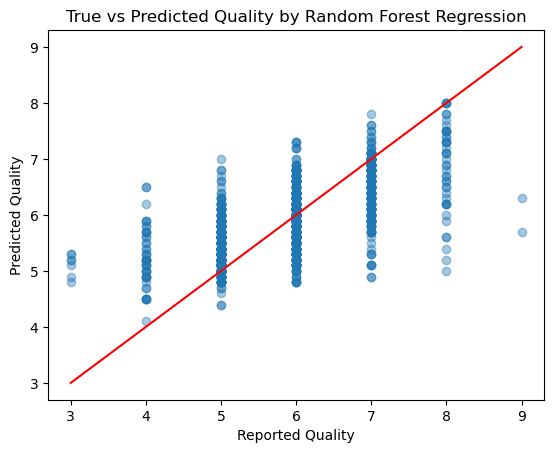

In [27]:
# Predictions on the test set:
y_pred = rf_model.predict(x_test)

# Creating a scatter plot of true vs predicted values (adding a straight line for the ideal relation): 
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=1.5)
plt.xlabel('Reported Quality')
plt.ylabel('Predicted Quality')
plt.title('True vs Predicted Quality by Random Forest Regression')
plt.show()

***Interpretation:*** Points close to the red line (x=y) indicate good predictions. According to this scatter plot, when the quality is around 6, it is more likely to be predicted about right. Large deviations from the line suggest the regions where the model's prediction capability is diverged from the actual values. When the quality is poor as with 3, 4, the model tends to predict it better quality between 4-7. And when the quality is as high as 7-9, the model tends to predict is worse than its actual value.  


**Assessing the Parameters for Random Forests**

As running the entire selection of trees with many repetitions is quite slow, 2 steps were followed here: 1) Results plotted with 2 repetitions for 5000 trees, 2) The part until 500 were repeated 20 times to ensure the similarity.

More trees with 2 repetitions


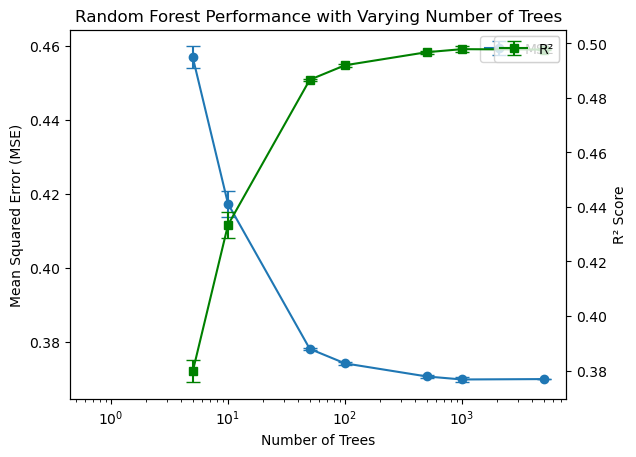

Less trees with 20 repetitions


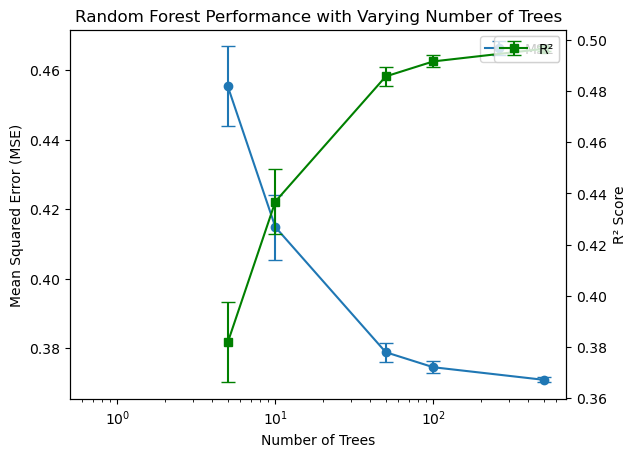

In [65]:
# PART 1: More trees with 2 repetitions
print('More trees with 2 repetitions')
tree_counts = [5, 10, 50, 100, 500, 1000, 5000]

mean_mse = []
std_mse = []
mean_r2 = []
std_r2 = []

for n_trees in tree_counts:
    mse_list = []
    r2_list = []
    for random_state in range(2):  
        rf_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_state)
        rf_model.fit(x_train, y_train)
        y_pred = rf_model.predict(x_test)
        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
    
    mean_mse.append(np.mean(mse_list))
    std_mse.append(np.std(mse_list))
    mean_r2.append(np.mean(r2_list))
    std_r2.append(np.std(r2_list))

fig, ax1 = plt.subplots()

ax1.errorbar(tree_counts, mean_mse, yerr=std_mse, fmt='-o', capsize=5, label='MSE')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Random Forest Performance with Varying Number of Trees')
ax1.legend()

ax2 = ax1.twinx()
ax2.errorbar(tree_counts, mean_r2, yerr=std_r2, fmt='-s', capsize=5, color='green', label='R²')
ax2.set_ylabel('R² Score')
ax2.legend(loc='upper right')

plt.show()



# PART 2: Less trees with 20 repetitions
print('Less trees with 20 repetitions')
tree_counts = [5, 10, 50, 100, 500]

mean_mse = []
std_mse = []
mean_r2 = []
std_r2 = []

for n_trees in tree_counts:
    mse_list = []
    r2_list = []
    for random_state in range(20):  
        rf_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_state)
        rf_model.fit(x_train, y_train)
        y_pred = rf_model.predict(x_test)
        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
    
    mean_mse.append(np.mean(mse_list))
    std_mse.append(np.std(mse_list))
    mean_r2.append(np.mean(r2_list))
    std_r2.append(np.std(r2_list))

fig, ax1 = plt.subplots()

ax1.errorbar(tree_counts, mean_mse, yerr=std_mse, fmt='-o', capsize=5, label='MSE')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Random Forest Performance with Varying Number of Trees')
ax1.legend()

ax2 = ax1.twinx()
ax2.errorbar(tree_counts, mean_r2, yerr=std_r2, fmt='-s', capsize=5, color='green', label='R²')
ax2.set_ylabel('R² Score')
ax2.legend(loc='upper right')

plt.show()



***Interpretation:*** As expected, the error was being stabilized at around 500 trees and get a steady decrease, reach a plateu; so it won't add a lot of value to further increase the number of trees but only slightly. So, it is a trade-off between model accuracy and computational efficiency. On the other hand, the increase of R2 with increasing number of trees suggests better model fit. With a higher number of trees, smaller error bars were achieved.    

***The Effect of Randomness:*** Randomness ensures a better performance for the current model and consistency for the future predictions. 
Intrinsic randomness of the random forest method is handled by this way which are training of each tree with a random subset in the forest (bootstrap sampling) and random selection of feature subsets. 
So, the model becomes robust against getting biased by particular random seeds and becomes more capable to generalize.

## Clustering

**k-Means Clustering**

Non-standardized data are used here and the quality indicator was also included in for unsupervised analysis, unlike the previous supervised analysis:

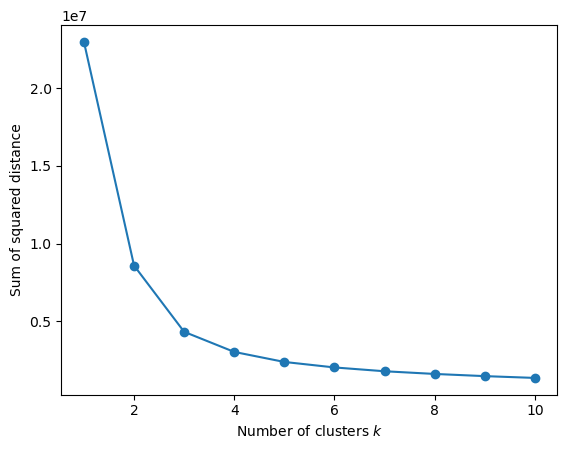

In [37]:
x = combined_wine_data.drop(columns=['QualityCategory'])   # removing only the categorical indicator


sse = []
list_k = list(range(1, 11))

for k in list_k:
    km = KMeans(n_clusters=k,n_init=10)
    km.fit(x)
    sse.append(km.inertia_)


plt.figure()
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Sum of squared distance');

# Finding the optimal number of clusters:

#plt.figure(figsize=(8, 6))
#plt.plot(range(1, 11), inertia_values, marker='o')
#plt.title('Elbow Method For Optimal Number of Clusters')
#plt.xlabel('Number of clusters')
#plt.ylabel('Inertia (Within-cluster sum of squares)')
#plt.show()


5 k points is chosen here, according to the elbow rule on the plot, where the inertia starts decreasing at a slower rate. After this, the slope of the decrease is very similar. To be fair, there are not certain truths unlike the supervised methods, e.g. 3 k in this plot may be a good trade-off as well. 

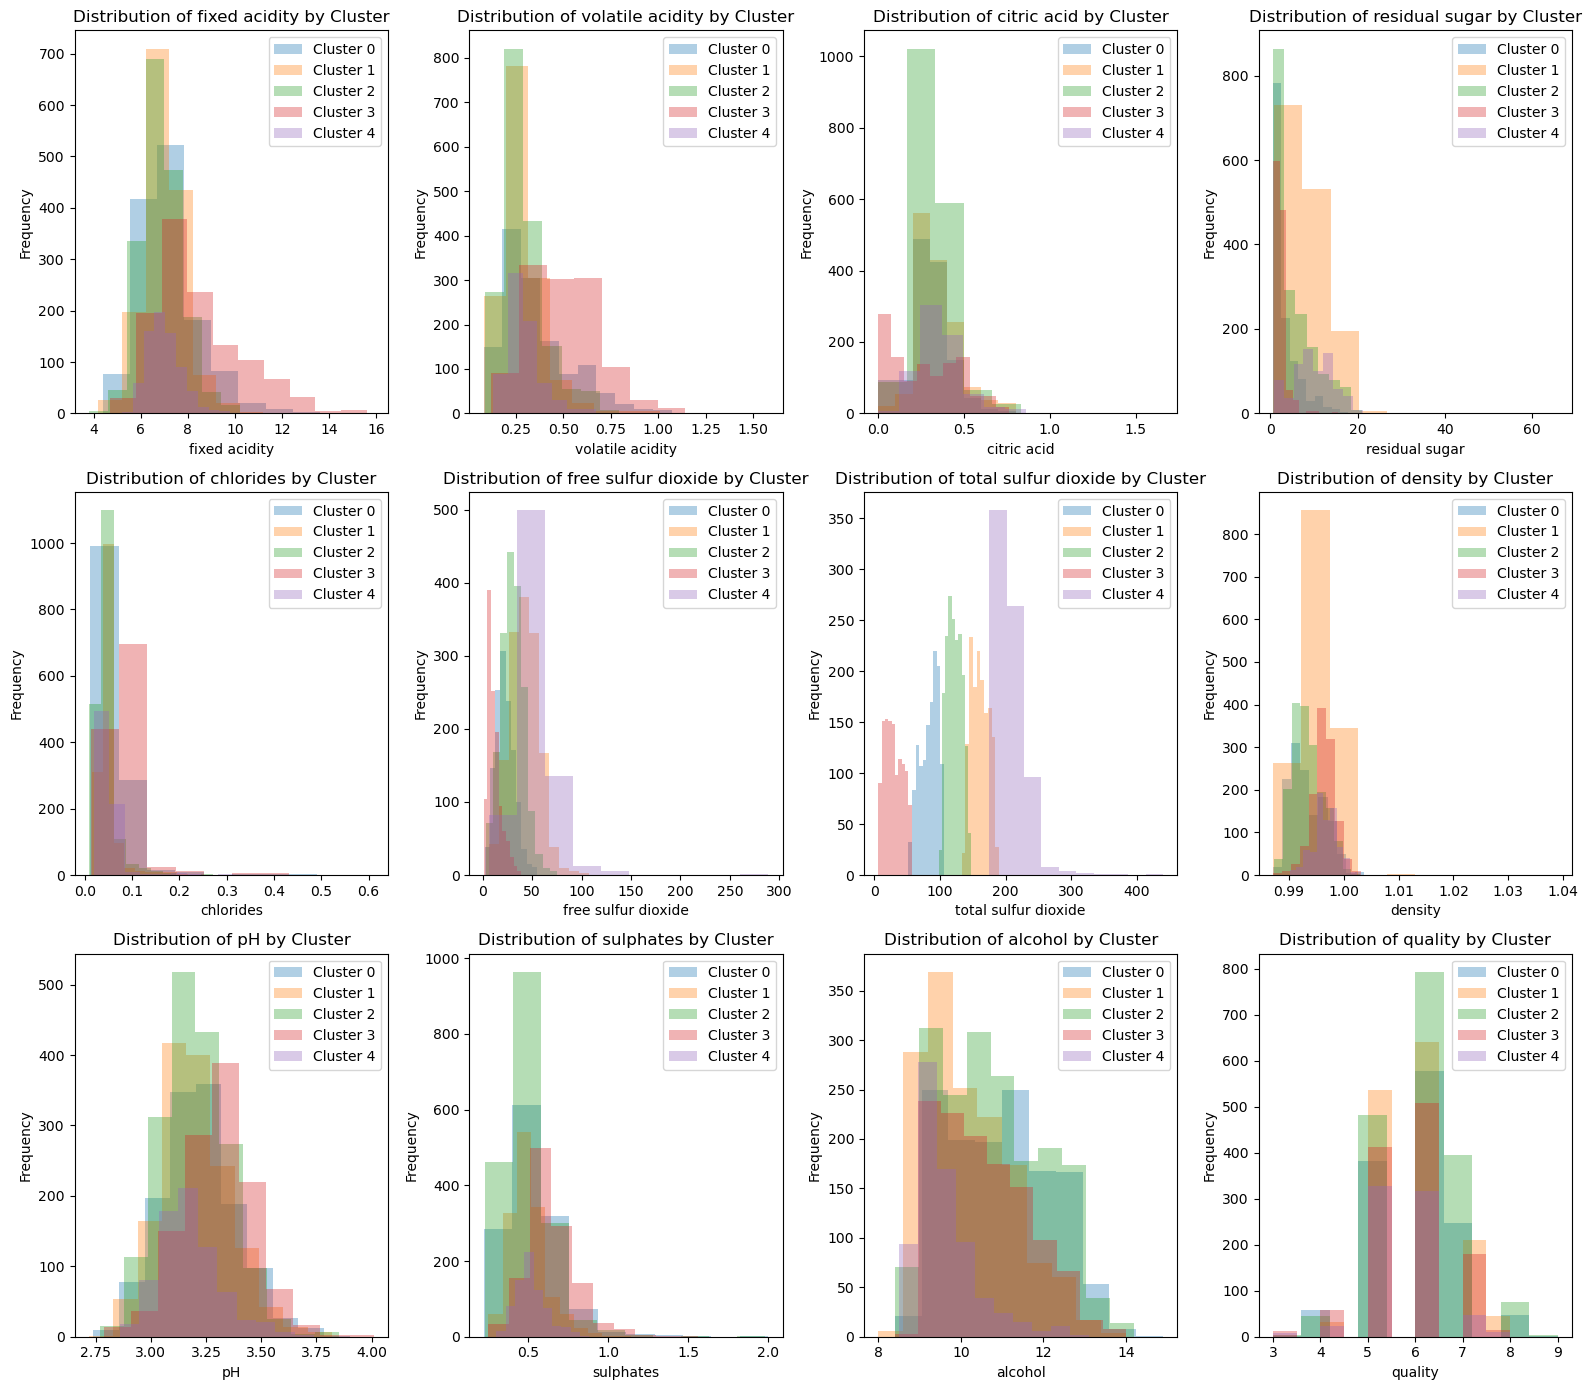

In [39]:
k = 5  
kmeans = KMeans(n_clusters=k)
kmeans.fit(x)

labels = kmeans.labels_

combined_wine_data['Cluster'] = labels

features = x.columns  
#print(features)
num_features = len(features)

fig, axes = plt.subplots(3, 4, figsize=(16, 14))  # 3 rows, 4 columns
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i, feature in enumerate(features):
    ax = axes[i]  # Get the subplot axis
    for cluster_num in range(k):
        subset = combined_wine_data[combined_wine_data['Cluster'] == cluster_num]
        ax.hist(subset[feature], alpha=0.35, label=f'Cluster {cluster_num}', bins=10)
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()

plt.show()



***Discussion:*** The most discriminatory variables can be selected by the hisograms, according to dinstinct separation of the clsuters. These featues help to make clear differenetiations. In these plots, the most discriminatory variables look like total sulfur dioxide, free sulfur dioxide, and chlorides. In case of total sulfur dioxide, we can see very distinct 5 clusters. In case of free sulfur dixoides, Cluster 2 and 0 are placed more on the left side; 4 in the middle and the other 2 clusters are wider with a large spread but the samples on the right side belong to them. In case of chlorides, Clusters 2 and 4 are on the right side, and the others are placed more on the left. 

***The Most Discriminatory Variables***

The most discriminatory variables in pairs:


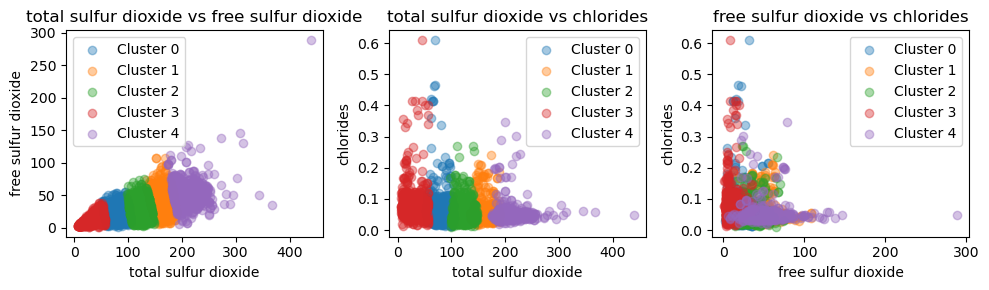



Total sulfur dioxide vs all other variables one by one:


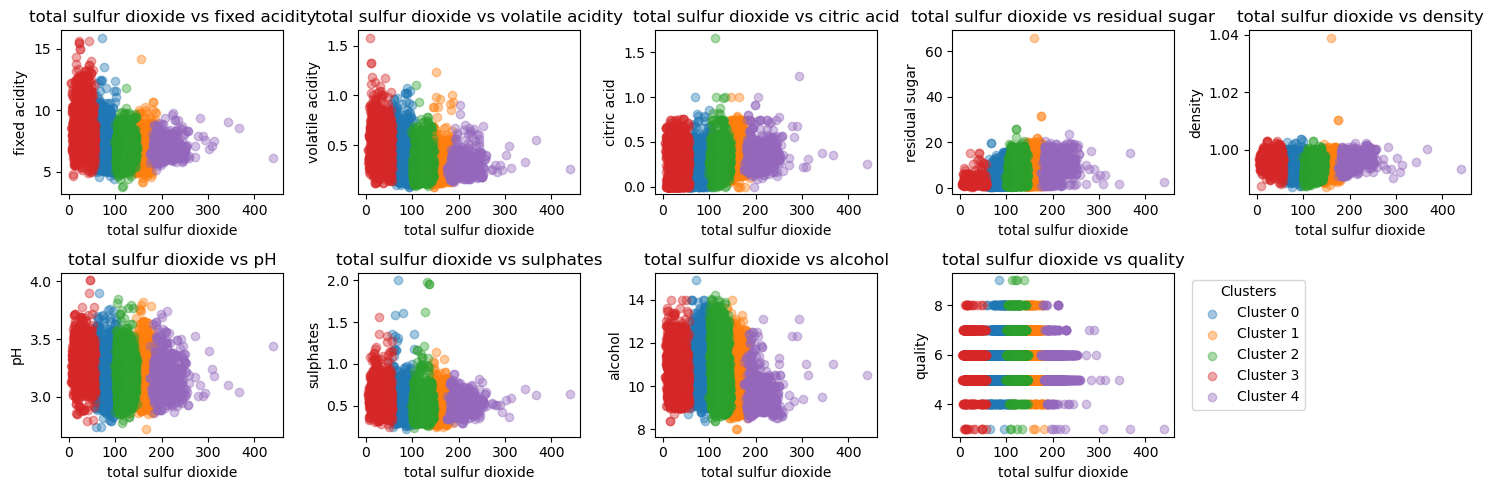

In [42]:
# Step 1: Most discriminatory variables:
discriminatory_vars = ['total sulfur dioxide', 'free sulfur dioxide', 'chlorides']

print('The most discriminatory variables in pairs:')

plt.figure(figsize=(10, 3))
plot_num = 1

for i in range(len(discriminatory_vars)):
    for j in range(i + 1, len(discriminatory_vars)):
        plt.subplot(1, 3, plot_num)
        for cluster_num in range(k):  
            subset = combined_wine_data[combined_wine_data['Cluster'] == cluster_num]
            plt.scatter(subset[discriminatory_vars[i]], subset[discriminatory_vars[j]], label=f'Cluster {cluster_num}', alpha=0.4)
        plt.xlabel(discriminatory_vars[i])
        plt.ylabel(discriminatory_vars[j])
        plt.title(f'{discriminatory_vars[i]} vs {discriminatory_vars[j]}')
        plt.legend()
        plot_num += 1

plt.tight_layout()
plt.show()


#EXTRA - Step 2: Total sulfur dioxide vs all variables
print('\n')
print('Total sulfur dioxide vs all other variables one by one:')
all_vars = combined_wine_data.columns.drop(['Cluster', 'total sulfur dioxide', 'QualityCategory', 'free sulfur dioxide', 'chlorides'])  #excluidng self references and previosuly plotted pairs
plt.figure(figsize=(15, 5))
plot_num = 1

for feature in all_vars:
    plt.subplot(2, 5, plot_num) 
    for cluster_num in range(k):
        subset = combined_wine_data[combined_wine_data['Cluster'] == cluster_num]
        plt.scatter(subset['total sulfur dioxide'], subset[feature], label=f'Cluster {cluster_num}', alpha=0.4)
    plt.xlabel('total sulfur dioxide')
    plt.ylabel(feature)
    plt.title(f'total sulfur dioxide vs {feature}')
    plot_num += 1
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Clusters')
plt.show()


***Discussion:*** Looking at the distinct groupings in the scatter plot, we see total vs free sulfur dioxides have the most evident separating clusters. While total sulfur dioxide vs chloride also has an enough distinct clustering, except cluster 1 which may have been mixed with two neighboring clusters (3 and 4 on the plot), this is less evident in the plot of free sulfur dioxides vs chlorides.

Looking at the further analysis of total sulfur dioxide vs each other indicator, we can see that this indicator has good clustering results with k-means method and 5 k chosen as the parameter.  


## Birch Clustering

BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) is particularly useful when the data is large. Unlike k-means, BIRCH can handle non-spherical clusters and parts that seem as outliers and is very efficient for large datasets.
KMeans can struggle with large datasets as it is iterative and computes distances between all points.

BIRCH's advantage is that clusters are not necessarily spherical.

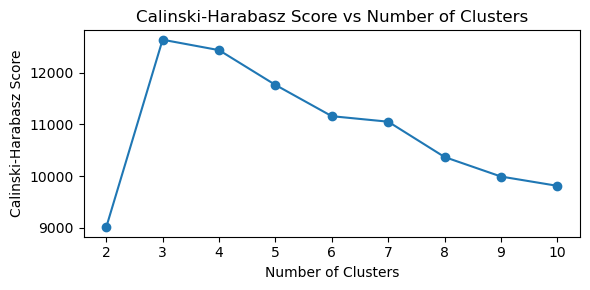

Optimal number of clusters based on Calinski-Harabasz Score: 3


In [46]:
n_clusters_range = range(1, 11)

# One of the methods to find the optimized no of the clusters: Calinski-Harabasz
ch_scores = []


for n_clusters in n_clusters_range:
    birch = Birch(n_clusters=n_clusters)
    labels_birch = birch.fit_predict(x)  # Using the original data (not scaled)
    
    # Calculate the Calinski-Harabasz score (only if n_clusters > 1)
    if n_clusters > 1:
        ch_scores.append(calinski_harabasz_score(x, labels_birch))
    else:
        ch_scores.append(np.nan)  # Not applicable for 1 cluster
    
  
# Plot Calinski-Harabasz Score 
plt.figure(figsize=(6, 3))

# Plot Calinski-Harabasz Score

plt.plot(n_clusters_range, ch_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs Number of Clusters')


plt.tight_layout()
plt.show()

optimal_n_clusters_ch = n_clusters_range[np.nanargmax(ch_scores)]


print(f"Optimal number of clusters based on Calinski-Harabasz Score: {optimal_n_clusters_ch}")


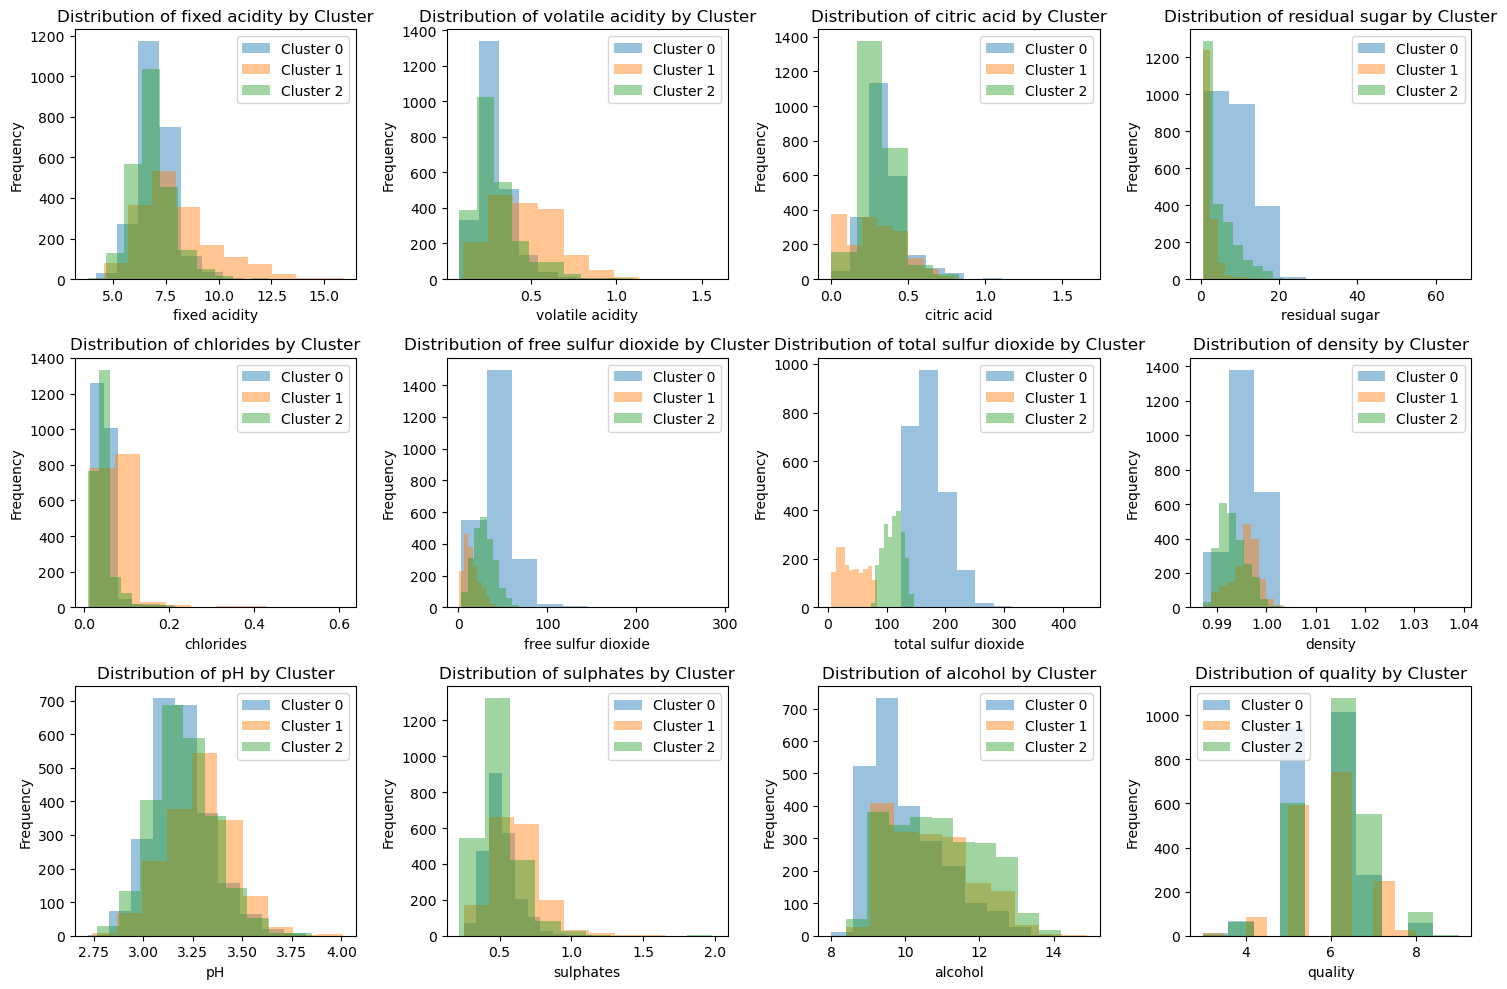

In [47]:
# Setting  the optimal number of clusters to 3:
optimal_n_clusters = 3

birch = Birch(n_clusters=optimal_n_clusters)
labels_birch = birch.fit_predict(x)  # Using the original data (not scaled)


combined_wine_data['Cluster'] = labels_birch

features = x.columns  

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  
axes = axes.flatten()  

for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_num in range(optimal_n_clusters):
        subset = combined_wine_data[combined_wine_data['Cluster'] == cluster_num]
        ax.hist(subset[feature], alpha=0.45, label=f'Cluster {cluster_num}')
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

Similar results were achieved with less number of clusters and more computational efficiency. Discriminatory variables are similar with addition of residual sugar. 

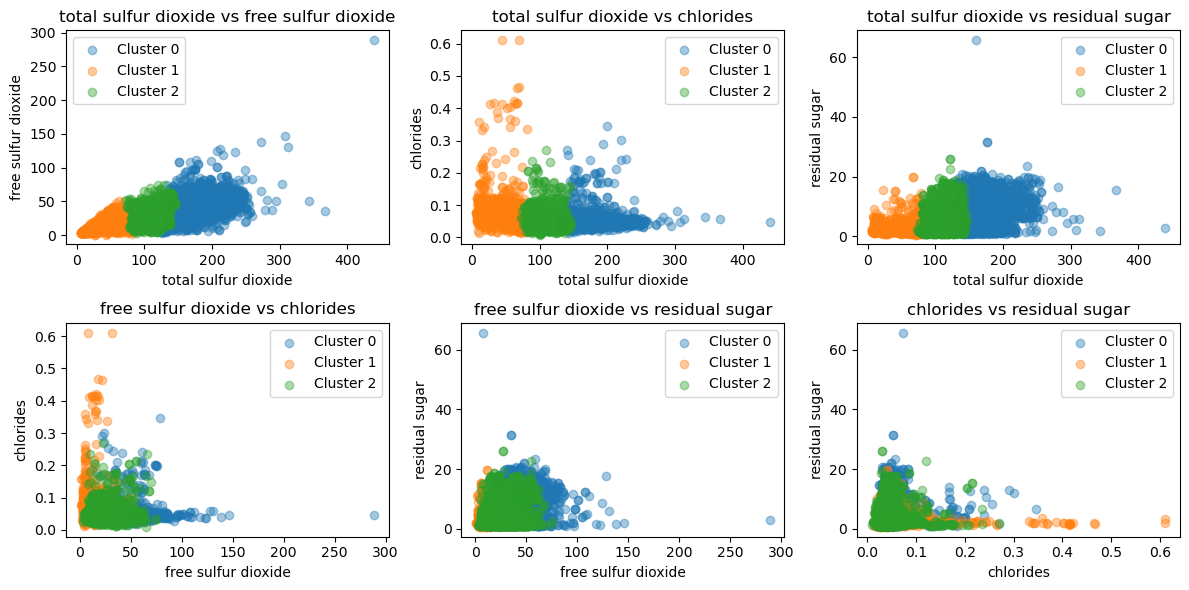

In [49]:
discriminatory_vars=['total sulfur dioxide', 'free sulfur dioxide', 'chlorides', 'residual sugar']

fig, axes = plt.subplots(2, 3, figsize=(12, 6)) 
axes = axes.flatten()  # 

plot_num = 0  
for i in range(len(discriminatory_vars)):
    for j in range(i + 1, len(discriminatory_vars)):
        ax = axes[plot_num]
       
        for cluster_num in range(optimal_n_clusters):
            subset = combined_wine_data[combined_wine_data['Cluster'] == cluster_num]
            ax.scatter(subset[discriminatory_vars[i]], subset[discriminatory_vars[j]], 
                       label=f'Cluster {cluster_num}', alpha=0.4)
        ax.set_xlabel(discriminatory_vars[i])
        ax.set_ylabel(discriminatory_vars[j])
        ax.set_title(f'{discriminatory_vars[i]} vs {discriminatory_vars[j]}')
        ax.legend()
        plot_num += 1


plt.tight_layout()
plt.show()

If we used 5 clusters as like in k-means:

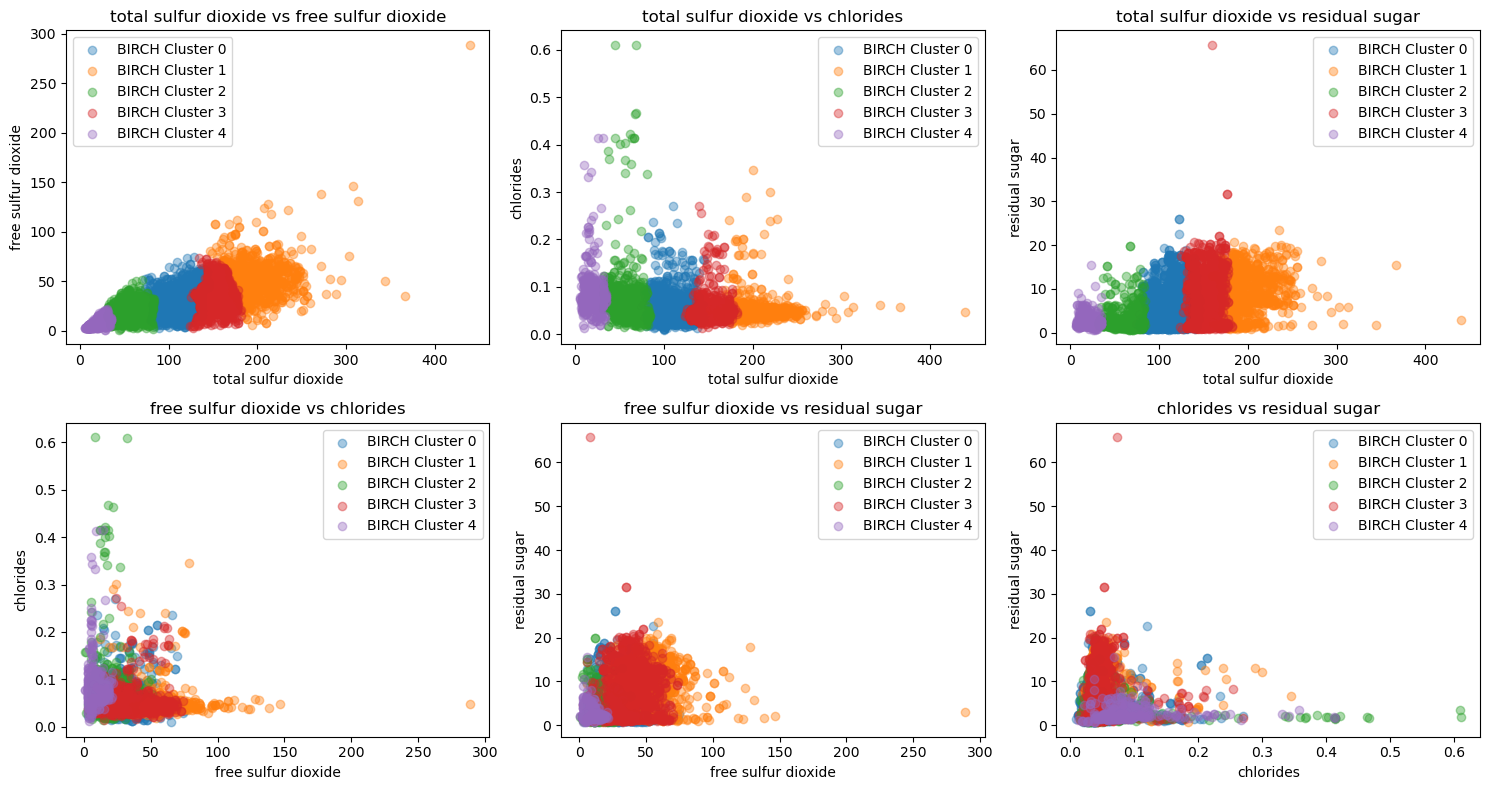

In [51]:
n_clusters_birch = 5
birch = Birch(n_clusters=n_clusters_birch)
birch_labels = birch.fit_predict(x)  


combined_wine_data['BIRCH_Cluster'] = birch_labels


discriminatory_vars = ['total sulfur dioxide', 'free sulfur dioxide', 'chlorides', 'residual sugar']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))  
axes = axes.flatten()  

plot_num = 0  

for i in range(len(discriminatory_vars)):
    for j in range(i + 1, len(discriminatory_vars)):
        ax = axes[plot_num]
        
       
        for cluster_num in range(n_clusters_birch):
            subset = combined_wine_data[combined_wine_data['BIRCH_Cluster'] == cluster_num]
            ax.scatter(subset[discriminatory_vars[i]], subset[discriminatory_vars[j]], 
                       label=f'BIRCH Cluster {cluster_num}', alpha=0.4)
   
        ax.set_xlabel(discriminatory_vars[i])
        ax.set_ylabel(discriminatory_vars[j])
        ax.set_title(f'{discriminatory_vars[i]} vs {discriminatory_vars[j]}')
        ax.legend()
        plot_num += 1


plt.tight_layout()
plt.show()

Very similar results; just the cluster of the potential outliers slightly change; and the samples which are relatively more far from the cluster center points do not necessarily stay in that cluster, to make more circular clusters. Instead, they are placed inside the clusters which has closer cluster centers (e.g. right side samples in free sulfur dioxide vs chloride, comparison of Birch and kmeans methods).

### Prepared by NAZAN ALTUN.